In [1]:
import pandas as pd
import numpy as np
import os 
import warnings
from sklearn.preprocessing import minmax_scale
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

warnings.filterwarnings('ignore')

In [2]:
wd_path = "/Users/seonukim/Documents/TMP/Data"
id = ['BTC', 'DOGE', 'ETH', 'XRP']

In [3]:
for i in id:
    for filename in os.listdir(wd_path+'/{}'.format(i)):
        if filename.endswith('.part'): 
            old_filepath = os.path.join(wd_path+'/{}'.format(i), filename) 
            new_filename = filename.replace('.part', '.csv')  
            new_filepath = os.path.join(wd_path+'/{}'.format(i), new_filename)  

            os.rename(old_filepath, new_filepath)  

print("파일 이름 변경이 완료되었습니다.")

파일 이름 변경이 완료되었습니다.


In [4]:
df_dict = {}

for i in id:
    csv_files = [f for f in os.listdir(os.path.join(wd_path, str(i))) if f.endswith('.csv')]

    df_list = []

    for csv_file in csv_files:
        df = pd.read_csv(os.path.join(wd_path, str(i), csv_file))
        df_list.append(df)

    df_dict[i] = pd.concat(df_list, ignore_index=True)

In [5]:
for i in id:
    df = df_dict[i]
    float_cols_df = df.select_dtypes(include=['float'])
    combined_df = pd.concat([float_cols_df, df['datetime'], df['type_websocket']], axis=1)
    df_dict[i] =combined_df

In [101]:
df_btc = df_dict['BTC']
df_doge = df_dict['DOGE']
df_eth = df_dict['ETH']
df_xrp = df_dict['XRP']

In [102]:
df_btc['datetime'] = pd.to_datetime(df_btc['datetime'])
df_btc = df_btc.set_index('datetime')
btc_orderbook = df_btc[df_btc['type_websocket']=='orderbook'].drop('type_websocket', axis=1).resample('10T').mean()
btc_orderbook['second_in_bucket'] = df_btc[df_btc['type_websocket']=='orderbook'].drop('type_websocket', axis=1)['orderbook_bp_12'].resample('10T').count()


In [9]:
btc_orderbook.head()

,opening_price,high_price,low_price,trade_price,prev_closing_price,change_price,signed_change_price,change_rate,signed_change_rate,trade_volume,...,orderbook_bs_12,orderbook_ap_13,orderbook_as_13,orderbook_bp_13,orderbook_bs_13,orderbook_ap_14,orderbook_as_14,orderbook_bp_14,orderbook_bs_14,second_in_bucket
datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-16 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.304996,2.259679e+07,0.317917,2.254150e+07,0.472208,2.259938e+07,0.315129,2.254038e+07,0.477686,858
2022-12-16 21:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.611384,2.259313e+07,0.816960,2.253990e+07,0.797572,2.259605e+07,0.486877,2.253890e+07,0.704002,1558
2022-12-16 21:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.434906,2.259897e+07,0.428125,2.254182e+07,0.635474,2.260306e+07,0.281906,2.254082e+07,0.746268,1552
2022-12-16 21:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.557424,2.259366e+07,0.441390,2.254369e+07,0.208041,2.259593e+07,0.572305,2.254269e+07,0.360742,1592
2022-12-16 21:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.074761,2.260509e+07,0.443605,2.255184e+07,4.639940,2.260959e+07,0.371359,2.255079e+07,3.839516,1356


In [94]:
btc_trade_vol = df_btc[df_btc['type_websocket']=='trade']
btc_trade_vol['log_return'] = np.log(btc_trade_vol['trade_price'] / btc_trade_vol['trade_price'].shift())
resampled = btc_trade_vol['log_return'].resample('10T')
btc_trade_vol['volatility'] = resampled.std()

btc_trade = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1).resample('10T').mean()
btc_trade['volatility'] = resampled.std()



,opening_price,high_price,low_price,trade_price,prev_closing_price,change_price,signed_change_price,change_rate,signed_change_rate,trade_volume,...,orderbook_bs_12,orderbook_ap_13,orderbook_as_13,orderbook_bp_13,orderbook_bs_13,orderbook_ap_14,orderbook_as_14,orderbook_bp_14,orderbook_bs_14,volatility
datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-16 21:05:30,NaN,NaN,NaN,2.256800e+07,22942000.0,374000.000000,NaN,NaN,NaN,0.010704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-16 21:05:40,NaN,NaN,NaN,2.256940e+07,22942000.0,372600.000000,NaN,NaN,NaN,0.125607,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-16 21:05:50,NaN,NaN,NaN,2.257000e+07,22942000.0,372000.000000,NaN,NaN,NaN,0.095589,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-16 21:06:00,NaN,NaN,NaN,2.256800e+07,22942000.0,374000.000000,NaN,NaN,NaN,0.063394,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-16 21:06:10,NaN,NaN,NaN,2.256867e+07,22942000.0,373333.333333,NaN,NaN,NaN,0.047640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 23:36:30,NaN,NaN,NaN,2.186170e+07,21891000.0,29300.000000,NaN,NaN,NaN,0.016671,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-23 23:36:40,NaN,NaN,NaN,2.185867e+07,21891000.0,32333.333333,NaN,NaN,NaN,0.020468,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-23 23:36:50,NaN,NaN,NaN,2.185490e+07,21891000.0,36095.238095,NaN,NaN,NaN,0.017825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
btc_trade['change_price'].isnull().sum()

5888

In [12]:
btc_orderbook = btc_orderbook.dropna(axis=1, how='all')
btc_trade = btc_trade.dropna(axis=1, how='all')

In [ ]:
btc_orderbook=btc_orderbook[1:-1]

In [13]:
btc_trade.columns

Index(['trade_price', 'prev_closing_price', 'change_price', 'trade_volume',
       'trade_timestamp', 'sequential_id', 'volatility'],
      dtype='object')

In [14]:
btc_orderbook.columns

Index(['total_ask_size', 'total_bid_size', 'orderbook_ap_0', 'orderbook_as_0',
       'orderbook_bp_0', 'orderbook_bs_0', 'orderbook_ap_1', 'orderbook_as_1',
       'orderbook_bp_1', 'orderbook_bs_1', 'orderbook_ap_2', 'orderbook_as_2',
       'orderbook_bp_2', 'orderbook_bs_2', 'orderbook_ap_3', 'orderbook_as_3',
       'orderbook_bp_3', 'orderbook_bs_3', 'orderbook_ap_4', 'orderbook_as_4',
       'orderbook_bp_4', 'orderbook_bs_4', 'orderbook_ap_5', 'orderbook_as_5',
       'orderbook_bp_5', 'orderbook_bs_5', 'orderbook_ap_6', 'orderbook_as_6',
       'orderbook_bp_6', 'orderbook_bs_6', 'orderbook_ap_7', 'orderbook_as_7',
       'orderbook_bp_7', 'orderbook_bs_7', 'orderbook_ap_8', 'orderbook_as_8',
       'orderbook_bp_8', 'orderbook_bs_8', 'orderbook_ap_9', 'orderbook_as_9',
       'orderbook_bp_9', 'orderbook_bs_9', 'orderbook_ap_10',
       'orderbook_as_10', 'orderbook_bp_10', 'orderbook_bs_10',
       'orderbook_ap_11', 'orderbook_as_11', 'orderbook_bp_11',
       'orderbook_bs

# Feature derive

## From orderbook

In [55]:
btc_derived_feature = pd.DataFrame()

# wap 계산
btc_derived_feature['wap1'] = (btc_orderbook['orderbook_bp_1'] * btc_orderbook['orderbook_as_1'] + btc_orderbook['orderbook_ap_1'] * btc_orderbook['orderbook_bs_1']) / (btc_orderbook['orderbook_bs_1'] + btc_orderbook['orderbook_as_1'])
btc_derived_feature['wap2'] = (btc_orderbook['orderbook_bp_2'] * btc_orderbook['orderbook_as_2'] + btc_orderbook['orderbook_ap_2'] * btc_orderbook['orderbook_bs_2']) / (btc_orderbook['orderbook_bs_2'] + btc_orderbook['orderbook_as_2'])

# 로그 수익률 계산
btc_derived_feature['log_return1'] = np.log(btc_derived_feature['wap1'] / btc_derived_feature['wap1'].shift())
btc_derived_feature['log_return2'] = np.log(btc_derived_feature['wap2'] / btc_derived_feature['wap2'].shift())
btc_derived_feature['log_return_ask1'] = np.log(btc_orderbook['orderbook_ap_1'] / btc_orderbook['orderbook_ap_1'].shift())
btc_derived_feature['log_return_ask2'] = np.log(btc_orderbook['orderbook_ap_2'] / btc_orderbook['orderbook_ap_2'].shift())
btc_derived_feature['log_return_bid1'] = np.log(btc_orderbook['orderbook_bp_1'] / btc_orderbook['orderbook_bp_1'].shift())
btc_derived_feature['log_return_bid2'] = np.log(btc_orderbook['orderbook_bp_2'] / btc_orderbook['orderbook_bp_2'].shift())

# wap_balance, price_spread, bid_spread, ask_spread 계산
btc_derived_feature['wap_balance'] = abs(btc_derived_feature['wap1'] - btc_derived_feature['wap2'])
btc_derived_feature['price_spread'] = btc_orderbook['orderbook_ap_1'] - btc_orderbook['orderbook_bp_1']
btc_derived_feature['bid_spread'] = btc_orderbook['orderbook_bp_1'] - btc_orderbook['orderbook_bp_2']
btc_derived_feature['ask_spread'] = btc_orderbook['orderbook_ap_1'] - btc_orderbook['orderbook_ap_2']

# total_volume, volume_imbalance 계산
btc_derived_feature['total_volume'] = btc_orderbook['orderbook_bs_1'] + btc_orderbook['orderbook_bs_2'] + btc_orderbook['orderbook_as_1'] + btc_orderbook['orderbook_as_2']
btc_derived_feature['volume_imbalance'] = (btc_orderbook['orderbook_bs_1'] + btc_orderbook['orderbook_bs_2']) - (btc_orderbook['orderbook_as_1'] + btc_orderbook['orderbook_as_2'])


In [56]:
window_sizes = [300, 150]

for window in window_sizes:
        btc_orderbook1 = df_btc[df_btc['type_websocket']=='orderbook'].drop('type_websocket', axis=1).resample(str(window)+'S').mean()
        btc_orderbook1['wap1'] = (btc_orderbook1['orderbook_bp_1'] * btc_orderbook1['orderbook_as_1'] + btc_orderbook1['orderbook_ap_1'] * btc_orderbook1['orderbook_bs_1']) / (btc_orderbook1['orderbook_bs_1'] + btc_orderbook1['orderbook_as_1'])
        btc_orderbook1['wap2'] = (btc_orderbook1['orderbook_bp_2'] * btc_orderbook1['orderbook_as_2'] + btc_orderbook1['orderbook_ap_2'] * btc_orderbook1['orderbook_bs_2']) / (btc_orderbook1['orderbook_bs_2'] + btc_orderbook1['orderbook_as_2'])


        # wap 계산
        btc_derived_feature[f'wap1_{window}_s'] = (btc_orderbook1['orderbook_bp_1'] * btc_orderbook1['orderbook_as_1'] + btc_orderbook1['orderbook_ap_1'] * btc_orderbook1['orderbook_bs_1']) / (btc_orderbook1['orderbook_bs_1'] + btc_orderbook1['orderbook_as_1'])
        btc_derived_feature[f'wap2_{window}_s'] = (btc_orderbook1['orderbook_bp_2'] * btc_orderbook1['orderbook_as_2'] + btc_orderbook1['orderbook_ap_2'] * btc_orderbook1['orderbook_bs_2']) / (btc_orderbook1['orderbook_bs_2'] + btc_orderbook1['orderbook_as_2'])

        # 로그 수익률 계산
        btc_derived_feature[f'log_return1_{window}_s'] = np.log(btc_orderbook1['wap1'] / btc_orderbook1['wap1'].shift())
        btc_derived_feature[f'log_return2_{window}_s'] = np.log(btc_orderbook1['wap2'] / btc_orderbook1['wap2'].shift())
        btc_derived_feature[f'log_return_ask1_{window}_s'] = np.log(btc_orderbook1['orderbook_ap_1'] / btc_orderbook1['orderbook_ap_1'].shift())
        btc_derived_feature[f'log_return_ask2_{window}_s'] = np.log(btc_orderbook1['orderbook_ap_2'] / btc_orderbook1['orderbook_ap_2'].shift())
        btc_derived_feature[f'log_return_bid1_{window}_s'] = np.log(btc_orderbook1['orderbook_bp_1'] / btc_orderbook1['orderbook_bp_1'].shift())
        btc_derived_feature[f'log_return_bid2_{window}_s'] = np.log(btc_orderbook1['orderbook_bp_2'] / btc_orderbook1['orderbook_bp_2'].shift())

        # wap_balance, price_spread, bid_spread, ask_spread 계산
        btc_derived_feature[f'wap_balance_{window}_s'] = abs(btc_orderbook1['wap1'] - btc_orderbook1['wap2'])
        btc_derived_feature[f'price_spread_{window}_s'] = btc_orderbook1['orderbook_ap_1'] - btc_orderbook1['orderbook_bp_1']
        btc_derived_feature[f'bid_spread_{window}_s'] = btc_orderbook1['orderbook_bp_1'] - btc_orderbook1['orderbook_bp_2']
        btc_derived_feature[f'ask_spread_{window}_s'] = btc_orderbook1['orderbook_ap_1'] - btc_orderbook1['orderbook_ap_2']

        # total_volume, volume_imbalance 계산
        btc_derived_feature[f'total_volume_{window}_s'] = btc_orderbook1['orderbook_bs_1'] + btc_orderbook1['orderbook_bs_2'] + btc_orderbook1['orderbook_as_1'] + btc_orderbook1['orderbook_as_2']
        btc_derived_feature[f'volume_imbalance_{window}_s'] = (btc_orderbook1['orderbook_bs_1'] + btc_orderbook1['orderbook_bs_2']) - (btc_orderbook1['orderbook_as_1'] + btc_orderbook1['orderbook_as_2'])

# btc_orderbook_features = pd.DataFrame()

# window_sizes = [450, 300, 150]

# for window in window_sizes:
#         btc_orderbook_features[f'wap1_{window}_s'] = btc_orderbook1['wap1'].transform(lambda x: x.rolling(window=window).mean())
#         btc_orderbook_features[f'wap2_{window}_s'] = btc_orderbook1['wap2'].transform(lambda x: x.rolling(window=window).mean())
#         btc_orderbook_features[f'log_return1_{window}_s'] = btc_orderbook1['log_return1'].transform(lambda x: x.rolling(window=window).std())
#         btc_orderbook_features[f'log_return2_{window}_s'] = btc_orderbook1['log_return2'].transform(lambda x: x.rolling(window=window).std())
#         btc_orderbook_features[f'log_return_ask1_{window}_s'] = btc_orderbook1['log_return_ask1'].transform(lambda x: x.rolling(window=window).std())
#         btc_orderbook_features[f'log_return_ask2_{window}_s'] = btc_orderbook1['log_return_ask2'].transform(lambda x: x.rolling(window=window).std())
#         btc_orderbook_features[f'log_return_bid1_{window}_s'] = btc_orderbook1['log_return_bid1'].transform(lambda x: x.rolling(window=window).std())
#         btc_orderbook_features[f'log_return_bid2_{window}_s'] = btc_orderbook1['log_return_bid2'].transform(lambda x: x.rolling(window=window).std())
#         btc_orderbook_features[f'wap_balance_{window}_s'] = btc_orderbook1['wap_balance'].transform(lambda x: x.rolling(window=window).mean())
#         btc_orderbook_features[f'price_spread_{window}_s'] = btc_orderbook1['price_spread'].transform(lambda x: x.rolling(window=window).mean())
#         btc_orderbook_features[f'bid_spread_{window}_s'] = btc_orderbook1['bid_spread'].transform(lambda x: x.rolling(window=window).mean())
#         btc_orderbook_features[f'ask_spread_{window}_s'] = btc_orderbook1['ask_spread'].transform(lambda x: x.rolling(window=window).mean())
#         btc_orderbook_features[f'total_volume_{window}_s'] = btc_orderbook1['total_volume'].transform(lambda x: x.rolling(window=window).sum())
#         btc_orderbook_features[f'volume_imbalance_{window}_s'] = btc_orderbook1['volume_imbalance'].transform(lambda x: x.rolling(window=window).mean())


In [57]:
btc_derived_feature.head()

,wap1,wap2,log_return1,log_return2,log_return_ask1,log_return_ask2,log_return_bid1,log_return_bid2,wap_balance,price_spread,...,log_return_ask1_150_s,log_return_ask2_150_s,log_return_bid1_150_s,log_return_bid2_150_s,wap_balance_150_s,price_spread_150_s,bid_spread_150_s,ask_spread_150_s,total_volume_150_s,volume_imbalance_150_s
datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-16 21:00:00,2.256515e+07,2.256868e+07,NaN,NaN,NaN,NaN,NaN,NaN,3526.197609,11564.102564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-16 21:10:00,2.256218e+07,2.256369e+07,-0.000132,-0.000221,-0.000213,-0.000267,-0.000116,-0.000104,1509.472562,9364.569961,...,-0.000019,-0.000055,0.000145,0.000087,1589.898693,7911.764706,2676.470588,-1600.000000,1.399914,-0.960185
2022-12-16 21:20:00,2.256421e+07,2.256825e+07,0.000090,0.000202,0.000257,0.000305,0.000054,0.000070,4034.736473,13951.030928,...,0.000088,0.000061,0.000030,0.000014,256.315473,9908.212560,1613.526570,-1884.057971,8.782462,6.203709
2022-12-16 21:30:00,2.256180e+07,2.256032e+07,-0.000107,-0.000351,-0.000079,-0.000046,0.000111,0.000109,1481.352220,9657.035176,...,-0.000153,-0.000072,0.000017,0.000017,4023.456316,9245.283019,1000.000000,-4600.000000,2.461082,-0.138934
2022-12-16 21:40:00,2.257042e+07,2.257230e+07,0.000382,0.000531,0.000301,0.000268,0.000449,0.000461,1880.055076,6318.584071,...,0.000005,-0.000031,0.000050,0.000075,1781.205453,5326.241135,1283.687943,-2702.127660,4.289448,1.068369


## From trade

In [58]:
btc_derived_feature['bucket_count'] = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1)['trade_volume'].resample('10T').count()

btc_trade_vol = df_btc[df_btc['type_websocket']=='trade']
btc_trade_vol['log_return'] = np.log(btc_trade_vol['trade_price'] / btc_trade_vol['trade_price'].shift())
resampled = btc_trade_vol['log_return'].resample('10T')
btc_trade_vol['volatility'] = resampled.std()
btc_derived_feature['volatility'] = resampled.std()

btc_derived_feature['size'] = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1)['trade_volume'].resample('10T').sum()

btc_derived_feature['order_count'] = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1)['trade_volume'].resample('10T').mean()


In [59]:
# 300s
btc_derived_feature['bucket_count_300_s'] = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1)['trade_volume'].resample('300S').count()

resampled = btc_trade_vol['log_return'].resample('300S')
btc_derived_feature['volatility_300_s'] = resampled.std()

btc_derived_feature['size_300_s'] = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1)['trade_volume'].resample('300S').sum()

btc_derived_feature['order_count_300_s'] = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1)['trade_volume'].resample('300S').mean()

# 150s
btc_derived_feature['bucket_count_150_s'] = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1)['trade_volume'].resample('150S').count()

resampled = btc_trade_vol['log_return'].resample('150S')
btc_derived_feature['volatility_150_s'] = resampled.std()

btc_derived_feature['size_150_s'] = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1)['trade_volume'].resample('150S').sum()

btc_derived_feature['order_count_150_s'] = df_btc[df_btc['type_websocket']=='trade'].drop('type_websocket', axis=1)['trade_volume'].resample('150S').mean()

In [60]:
btc_derived_feature['after_10m_volatility'] = btc_derived_feature['volatility'].shift(-1)
btc_derived_feature[['volatility', 'after_10m_volatility']].head()

,volatility,after_10m_volatility
datetime,,
2022-12-16 21:00:00,0.001215,0.000097
2022-12-16 21:10:00,0.000097,0.000168
2022-12-16 21:20:00,0.000168,0.000119
2022-12-16 21:30:00,0.000119,0.000061
2022-12-16 21:40:00,0.000061,0.000091


In [61]:
# btc_trade_features = pd.DataFrame()

# for window in window_sizes:
#     btc_trade_features[f'bucket_count_{window}_s'] = btc_trade_vol['trade_volume'].groupby('datetime').count().rolling(window=window).sum()
#     btc_trade_features[f'volatility_{window}_s'] = btc_trade_vol['log_return'].rolling(window=window).std().groupby('datetime').mean()
#     btc_trade_features[f'size_{window}_s'] = btc_trade_vol['trade_volume'].groupby('datetime').sum().rolling(window=window).sum()
#     btc_trade_features[f'ordercount_{window}_s'] = btc_trade_vol['trade_volume'].groupby('datetime').mean().rolling(window=window).mean()


In [62]:
btc_derived_feature.head()

,wap1,wap2,log_return1,log_return2,log_return_ask1,log_return_ask2,log_return_bid1,log_return_bid2,wap_balance,price_spread,...,order_count,bucket_count_300_s,volatility_300_s,size_300_s,order_count_300_s,bucket_count_150_s,volatility_150_s,size_150_s,order_count_150_s,after_10m_volatility
datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-16 21:00:00,2.256515e+07,2.256868e+07,NaN,NaN,NaN,NaN,NaN,NaN,3526.197609,11564.102564,...,0.071725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000097
2022-12-16 21:10:00,2.256218e+07,2.256369e+07,-0.000132,-0.000221,-0.000213,-0.000267,-0.000116,-0.000104,1509.472562,9364.569961,...,0.023193,426.0,0.000076,9.803830,0.023014,142.0,0.000080,4.105456,0.028912,0.000168
2022-12-16 21:20:00,2.256421e+07,2.256825e+07,0.000090,0.000202,0.000257,0.000305,0.000054,0.000070,4034.736473,13951.030928,...,0.073482,452.0,0.000126,47.360994,0.104781,248.0,0.000061,41.318683,0.166608,0.000119
2022-12-16 21:30:00,2.256180e+07,2.256032e+07,-0.000107,-0.000351,-0.000079,-0.000046,0.000111,0.000109,1481.352220,9657.035176,...,0.039757,330.0,0.000133,10.991375,0.033307,142.0,0.000016,4.721475,0.033250,0.000061
2022-12-16 21:40:00,2.257042e+07,2.257230e+07,0.000382,0.000531,0.000301,0.000268,0.000449,0.000461,1880.055076,6318.584071,...,0.042241,296.0,0.000046,15.626368,0.052792,122.0,0.000058,6.364540,0.052168,0.000091


In [63]:
btc_derived_feature.reset_index(inplace=True)
btc_derived_feature.drop(columns='datetime', inplace=True)
btc_derived_feature.head()

,wap1,wap2,log_return1,log_return2,log_return_ask1,log_return_ask2,log_return_bid1,log_return_bid2,wap_balance,price_spread,...,order_count,bucket_count_300_s,volatility_300_s,size_300_s,order_count_300_s,bucket_count_150_s,volatility_150_s,size_150_s,order_count_150_s,after_10m_volatility
0,2.256515e+07,2.256868e+07,NaN,NaN,NaN,NaN,NaN,NaN,3526.197609,11564.102564,...,0.071725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000097
1,2.256218e+07,2.256369e+07,-0.000132,-0.000221,-0.000213,-0.000267,-0.000116,-0.000104,1509.472562,9364.569961,...,0.023193,426.0,0.000076,9.803830,0.023014,142.0,0.000080,4.105456,0.028912,0.000168
2,2.256421e+07,2.256825e+07,0.000090,0.000202,0.000257,0.000305,0.000054,0.000070,4034.736473,13951.030928,...,0.073482,452.0,0.000126,47.360994,0.104781,248.0,0.000061,41.318683,0.166608,0.000119
3,2.256180e+07,2.256032e+07,-0.000107,-0.000351,-0.000079,-0.000046,0.000111,0.000109,1481.352220,9657.035176,...,0.039757,330.0,0.000133,10.991375,0.033307,142.0,0.000016,4.721475,0.033250,0.000061
4,2.257042e+07,2.257230e+07,0.000382,0.000531,0.000301,0.000268,0.000449,0.000461,1880.055076,6318.584071,...,0.042241,296.0,0.000046,15.626368,0.052792,122.0,0.000058,6.364540,0.052168,0.000091


# Nearest Neighbor features

In [70]:
btc_nn_features_scaled = pd.DataFrame()

btc_nn_features_scaled['tick_size'] = minmax_scale((btc_orderbook['orderbook_ap_0']-btc_orderbook['orderbook_bp_0'])/100)
btc_nn_features_scaled['vol'] = minmax_scale(btc_derived_feature['volatility'])
btc_nn_features_scaled['tau'] = minmax_scale(np.sqrt(1/(btc_derived_feature['bucket_count'])))
btc_nn_features_scaled['size'] = minmax_scale(btc_derived_feature['size'])
btc_nn_features_scaled = btc_nn_features_scaled[1:-1].reset_index()
btc_nn_features_scaled.drop(columns='index', inplace=True)

btc_nn_features_scaled.head()

,tick_size,vol,tau,size
0,0.155267,0.057842,0.299384,0.024962
1,0.251111,0.108676,0.285340,0.091637
2,0.141534,0.074076,0.335212,0.036850
3,0.082955,0.032229,0.352999,0.035938
4,0.162032,0.053849,0.261380,0.066156


# Index extraction

In [71]:
# nan 값 포함행 제거
btc_derived_feature = btc_derived_feature.dropna(how= 'any', axis = 0).reset_index()

In [72]:
n_neighbors = 10  # Set number of neighbors

metrics = {
    'tick_size': ['canberra', 'minkowski'],
    'vol': ['minkowski'],
    'size': ['canberra', 'minkowski'],
    'all_features': ['canberra', 'mahalanobis', 'minkowski']
}


nearest_neighbors_per_feature = {}

# Loop through each feature
for feature in metrics.keys():
    if feature == 'all_features':
        data = btc_nn_features_scaled
    else:
        data = btc_nn_features_scaled[feature].values.reshape(-1, 1)

    for metric in metrics[feature]:
        # Fit nearest neighbors
        if metric == 'mahalanobis':
            V = np.cov(data, rowvar=False)
            VI = np.linalg.inv(V)
            distances = cdist(data, data, metric='mahalanobis', VI=VI)
            indices = np.argsort(distances, axis=1)[:,:n_neighbors]
        else:
            nn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric)
            nn.fit(data)
            _, indices = nn.kneighbors(data)

        # Create a dataframe from the indices
        nearest_neighbors_df = pd.DataFrame(indices, columns=[f'top{i+1}' for i in range(n_neighbors)], index=btc_nn_features_scaled.index)

        # Save the dataframe in the dictionary
        nearest_neighbors_per_feature[f'{feature}_{metric}'] = nearest_neighbors_df


In [73]:
time_ticksize_c = nearest_neighbors_per_feature['tick_size_canberra']
time_ticksize_m = nearest_neighbors_per_feature['tick_size_minkowski']
time_size_c = nearest_neighbors_per_feature['size_canberra']
time_size_m = nearest_neighbors_per_feature['size_minkowski']
time_vol_l1 = nearest_neighbors_per_feature['vol_minkowski']
time_all_c = nearest_neighbors_per_feature['all_features_canberra']
time_all_m = nearest_neighbors_per_feature['all_features_minkowski']
time_all_ma = nearest_neighbors_per_feature['all_features_mahalanobis']

In [74]:
time_ticksize_c.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
0,0,856,921,676,549,491,382,222,674,234
1,1,305,554,348,787,903,807,193,702,994
2,2,943,853,57,256,399,836,617,12,183
3,3,816,84,1012,376,568,427,127,677,789
4,4,534,848,796,435,888,701,48,681,80


In [75]:
time_ticksize_m.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
0,0,856,921,676,549,491,382,222,674,234
1,1,305,554,348,787,903,807,193,702,994
2,2,943,853,57,256,399,836,617,12,183
3,3,816,84,1012,376,568,127,427,677,789
4,4,534,848,796,435,888,701,48,681,80


In [76]:
time_size_c.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
0,0,149,461,899,470,835,130,277,157,263
1,1,361,209,847,528,151,173,281,508,862
2,2,989,855,986,957,473,390,588,845,444
3,3,434,298,682,852,179,829,639,685,299
4,4,370,601,715,884,121,359,94,14,380


In [77]:
time_size_m.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
0,0,149,461,899,470,835,130,277,157,263
1,1,361,209,847,528,151,173,281,508,862
2,2,989,855,986,957,473,390,588,845,444
3,3,434,298,682,852,179,829,639,685,299
4,4,370,601,715,884,121,359,94,14,380


In [78]:
time_vol_l1.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
0,0,505,711,821,221,143,613,151,612,165
1,1,324,990,102,698,572,841,339,72,605
2,2,555,983,551,358,587,938,307,878,386
3,3,12,659,795,852,48,97,203,714,488
4,4,399,560,1003,503,847,654,251,436,594


In [79]:
time_all_c.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
0,0,222,888,899,560,125,159,276,56,115
1,1,361,864,558,209,291,672,828,288,524
2,2,549,295,517,796,445,243,222,390,921
3,3,1012,434,250,852,391,928,659,156,488
4,4,674,711,382,679,105,104,285,822,94


In [80]:
time_all_m.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
0,0,888,921,222,517,842,409,390,587,115
1,1,1019,209,273,672,864,678,14,887,964
2,2,295,517,445,549,222,399,796,243,1014
3,3,434,250,391,1012,237,707,396,157,211
4,4,674,711,679,998,822,382,577,414,31


In [81]:
time_all_ma.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
0,0,888,143,485,921,842,587,222,115,651
1,1,864,550,361,672,526,887,976,1019,673
2,2,295,549,517,243,919,445,442,409,950
3,3,434,250,1012,391,157,928,396,707,433
4,4,674,711,679,286,577,705,383,650,686


# Rank correlation

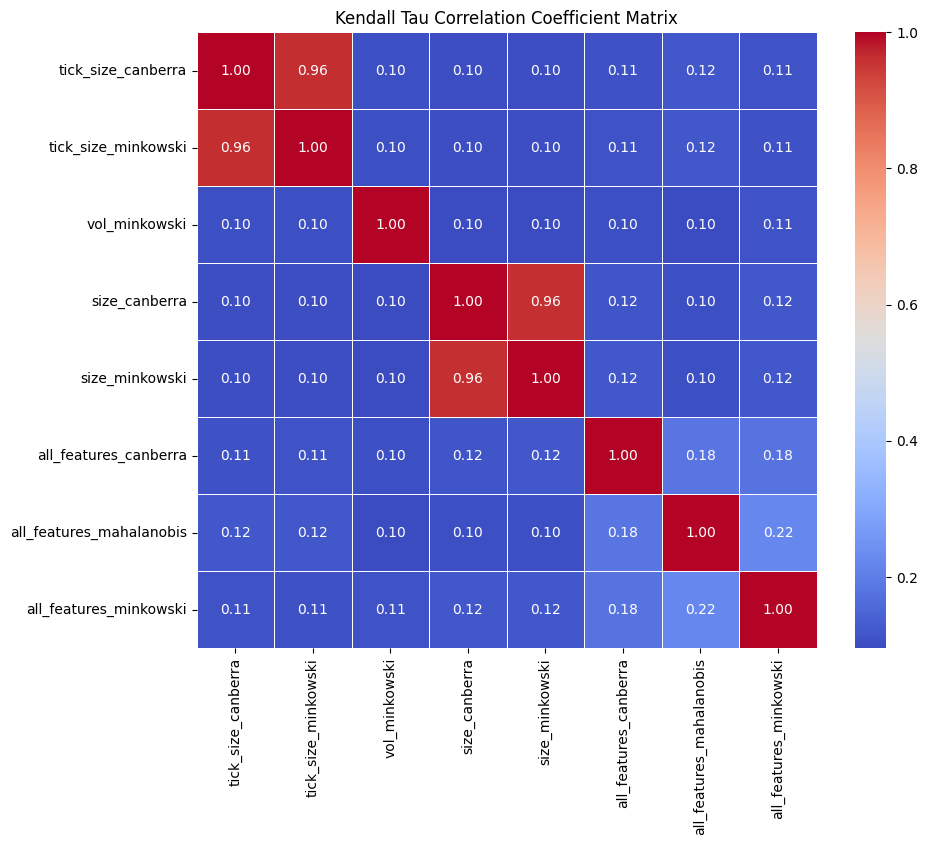

In [82]:
kendall_corr_matrix = pd.DataFrame(index=nearest_neighbors_per_feature.keys(), columns=nearest_neighbors_per_feature.keys())

for df_name1, df1 in nearest_neighbors_per_feature.items():
    for df_name2, df2 in nearest_neighbors_per_feature.items():
        corr_values = []
        for column in df1.columns:
            tau, _ = kendalltau(df1[column], df2[column])
            corr_values.append(tau)
        kendall_corr_matrix.loc[df_name1, df_name2] = np.mean(corr_values)
        
kendall_corr_matrix = kendall_corr_matrix.astype(float)

plt.figure(figsize=(10, 8))
sns.heatmap(kendall_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Kendall Tau Correlation Coefficient Matrix")
plt.show()


# Extract features

In [83]:
feature_df = pd.DataFrame()

del nearest_neighbors_per_feature['tick_size_minkowski']
del nearest_neighbors_per_feature['size_minkowski']


for df_name1, df1 in nearest_neighbors_per_feature.items():
    for col in btc_derived_feature.columns:
        feature_df[col+'_'+df_name1] = df1.apply(lambda row: btc_derived_feature.loc[row, col].mean(), axis=1)


In [84]:
feature_df

,index_tick_size_canberra,wap1_tick_size_canberra,wap2_tick_size_canberra,log_return1_tick_size_canberra,log_return2_tick_size_canberra,log_return_ask1_tick_size_canberra,log_return_ask2_tick_size_canberra,log_return_bid1_tick_size_canberra,log_return_bid2_tick_size_canberra,wap_balance_tick_size_canberra,...,order_count_all_features_minkowski,bucket_count_300_s_all_features_minkowski,volatility_300_s_all_features_minkowski,size_300_s_all_features_minkowski,order_count_300_s_all_features_minkowski,bucket_count_150_s_all_features_minkowski,volatility_150_s_all_features_minkowski,size_150_s_all_features_minkowski,order_count_150_s_all_features_minkowski,after_10m_volatility_all_features_minkowski
0,501.5,2.203641e+07,2.203681e+07,-0.000288,-0.000283,-0.000329,-0.000328,-0.000254,-0.000243,1524.834678,...,0.030141,371.0,0.000104,11.462528,0.030059,179.8,0.000118,5.800724,0.031309,0.000134
1,560.4,2.204153e+07,2.204077e+07,0.000167,0.000086,0.000115,0.000131,0.000138,0.000140,2173.192961,...,0.058009,438.6,0.000126,25.581014,0.057722,217.4,0.000121,13.264451,0.058840,0.000115
2,416.8,2.213338e+07,2.213444e+07,0.000006,0.000025,0.000010,0.000034,0.000005,-0.000003,1750.959255,...,0.042105,314.0,0.000116,12.399473,0.038924,166.0,0.000096,5.947866,0.035130,0.000119
3,488.9,2.205134e+07,2.205199e+07,-0.000547,-0.000519,-0.000585,-0.000581,-0.000448,-0.000437,1341.601462,...,0.043513,261.0,0.000044,12.030343,0.046511,127.8,0.000041,6.293853,0.047562,0.000104
4,502.5,2.208547e+07,2.208562e+07,0.000275,0.000243,0.000317,0.000326,0.000322,0.000323,1456.710271,...,0.050308,391.6,0.000094,18.686742,0.048255,179.0,0.000078,7.658526,0.044179,0.000121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,416.6,2.210149e+07,2.210086e+07,0.000594,0.000537,0.000494,0.000476,0.000560,0.000558,1202.368384,...,0.062532,918.8,0.000111,55.500477,0.061061,425.2,0.000113,24.570905,0.058457,0.000140
1018,501.6,2.207671e+07,2.207654e+07,-0.000143,-0.000163,-0.000075,-0.000067,-0.000133,-0.000138,1969.979171,...,0.041452,537.0,0.000125,21.469012,0.040308,249.2,0.000146,10.827702,0.046286,0.000128
1019,665.0,2.198033e+07,2.198030e+07,-0.000296,-0.000307,-0.000240,-0.000259,-0.000287,-0.000275,1733.182296,...,0.043459,408.2,0.000134,17.528286,0.042665,182.8,0.000126,6.652470,0.036884,0.000137
1020,560.1,2.193726e+07,2.193805e+07,0.000171,0.000199,0.000070,0.000062,0.000235,0.000240,1897.550717,...,0.052936,342.6,0.000085,18.037324,0.053533,186.6,0.000088,9.973632,0.053500,0.000158
